In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Load the datasets
# customer_data contains demographic and category features, while payment_data holds payment history
customer_data = pd.read_csv("data\customer_data.csv")
payment_data = pd.read_csv("data\payment_data.csv")

customer_data

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0,58988196,5,1289.0,1,173000.0,2,15,5,112,3,350702,200.000000
1121,0,58987926,5,NaN,2,50000.0,2,15,5,108,4,450000,169.000000
1122,0,58995381,7,1220.0,3,76000.0,2,11,2,90,5,71002,1.000000
1123,0,58998054,4,1250.0,3,137000.0,2,8,5,90,5,72000,1.000000


In [2]:
payment_data

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016
...,...,...,...,...,...,...,...,...,...,...,...,...
8245,58995478,0,0,0,0,9,15,NaN,NaN,0.0,NaN,NaN
8246,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN
8247,54988209,0,0,0,0,5,13,NaN,NaN,20654.4,33315.0,NaN
8248,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN


In [3]:

# Merge both datasets on 'id' to bring together customer details and payment history
merged_data = pd.merge(customer_data, payment_data, on='id', how='left')

# Handling missing values where necessary
merged_data.loc[:, 'fea_2'] = merged_data['fea_2'].fillna(merged_data['fea_2'].median())
merged_data.loc[:, 'prod_limit'] = merged_data['prod_limit'].fillna(merged_data['prod_limit'].median())
merged_data.loc[:, 'highest_balance'] = merged_data['highest_balance'].fillna(merged_data['new_balance'])

# Feature Engineering: Creating new financial indicators
# - Credit Utilization Ratio: Measures how much credit is used compared to the limit
# - Overdue Payment Frequency: Tracks how often payments are overdue
# - Debt Burden Ratio: Measures the proportion of debt relative to income
merged_data['credit_utilization_ratio'] = merged_data['new_balance'] / merged_data['prod_limit']
merged_data['overdue_payment_frequency'] = (merged_data['OVD_t1'] + merged_data['OVD_t2'] + merged_data['OVD_t3']) / (merged_data['pay_normal'] + 1)  # Adding 1 to avoid division by zero
merged_data['debt_burden_ratio'] = merged_data['new_balance'] / merged_data['fea_10']

# Selecting the features we want to use for training our model
features = ['OVD_t3', 'fea_8','fea_10', 'fea_2', 'fea_6', 'fea_5', 
            'prod_limit', 'highest_balance', 'fea_9', 'fea_11', 'fea_3', 
            'new_balance', 'fea_7', 'pay_normal', 'fea_4', 'OVD_t1', 'prod_code', 'OVD_sum', 
            'fea_1', 'OVD_t2']
X = merged_data[features]  # Independent variables
y = merged_data['label']   # Target variable (1 = high risk, 0 = low risk)





In [4]:
# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standarize data to increase model quality
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing our machine learning models
log_reg = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)  # Logistic Regression for baseline performance
decision_tree = DecisionTreeClassifier(random_state=42)  # Decision Tree for non-linear decision making
xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # XGBoost for more advanced boosting-based predictions

# Training all three models
log_reg.fit(X_train_scaled, y_train)
decision_tree.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making predictions using our trained models
log_reg_preds = log_reg.predict(X_test_scaled)
decision_tree_preds = decision_tree.predict(X_test)
xgb_preds = xgb.predict(X_test)

                 Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression  0.833939   0.800000  0.014440  0.506856
1        Decision Tree  0.964848   0.892473  0.898917  0.938534
2              XGBoost  0.987273   0.992308  0.931408  0.964976


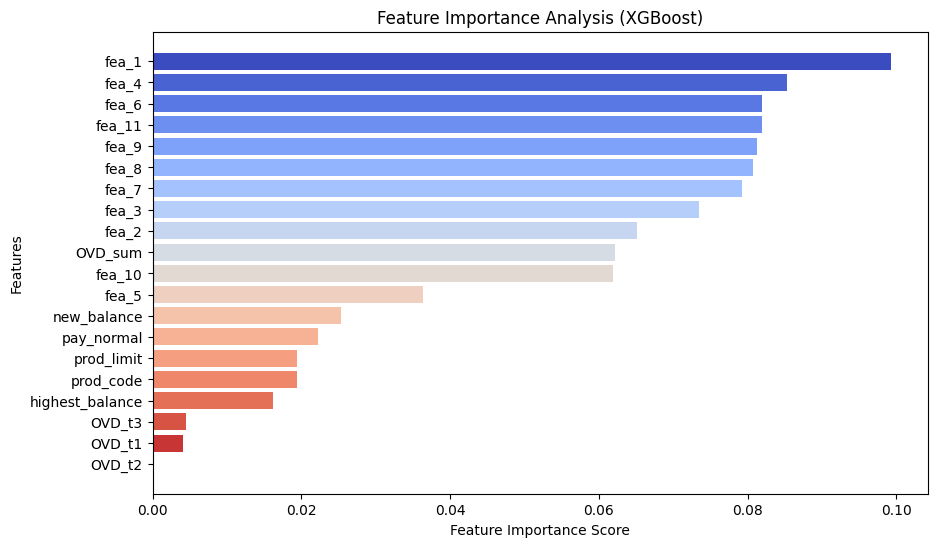

In [5]:
# Function to evaluate model performance using common classification metrics
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

# Collecting results from all three models
results = [
    evaluate_model(y_test, log_reg_preds, "Logistic Regression"),
    evaluate_model(y_test, decision_tree_preds, "Decision Tree"),
    evaluate_model(y_test, xgb_preds, "XGBoost")
]

# Displaying the model performance comparison
results_df = pd.DataFrame(results)
print(results_df)

# Analyzing which features were the most important in the XGBoost model
importances = xgb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]  # Sorting in descending order
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = importances[sorted_indices]

colors = plt.cm.coolwarm(np.linspace(0, 1, len(features)))

# Plot feature importance using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color=colors)  # Horizontal bar chart
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (XGBoost)")
plt.gca().invert_yaxis()  # Invert so most important is at the top
plt.style.use("ggplot")
plt.show()

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define number of folds
k_folds = 5
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Perform k-fold cross-validation and store detailed results
cross_val_results = []

# Perform k-fold cross-validation with additional metrics
metrics = ['accuracy', 'precision', 'recall', 'roc_auc']
for model_name, model in models.items():
    model_results = {"Model": model_name}
    for metric in metrics:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=stratified_kfold, scoring=metric)
        model_results[f"Mean {metric.capitalize()}"] = np.mean(scores)
        model_results[f"Std Dev {metric.capitalize()}"] = np.std(scores)
    cross_val_results.append(model_results)

# Convert results to DataFrame and display
no_feature_cross_val_results_df = pd.DataFrame(cross_val_results)
no_feature_cross_val_results_df

In [ ]:

# Merge both datasets on 'id' to bring together customer details and payment history
merged_data = pd.merge(customer_data, payment_data, on='id', how='left')

# Handling missing values where necessary
merged_data.loc[:, 'fea_2'] = merged_data['fea_2'].fillna(merged_data['fea_2'].median())
merged_data.loc[:, 'prod_limit'] = merged_data['prod_limit'].fillna(merged_data['prod_limit'].median())
merged_data.loc[:, 'highest_balance'] = merged_data['highest_balance'].fillna(merged_data['new_balance'])

# Feature Engineering: Creating new financial indicators
# - Credit Utilization Ratio: Measures how much credit is used compared to the limit
# - Overdue Payment Frequency: Tracks how often payments are overdue
# - Debt Burden Ratio: Measures the proportion of debt relative to income
merged_data['credit_utilization_ratio'] = merged_data['new_balance'] / merged_data['prod_limit']
merged_data['overdue_payment_frequency'] = (merged_data['OVD_t1'] + merged_data['OVD_t2'] + merged_data['OVD_t3']) / (merged_data['pay_normal'] + 1)  # Adding 1 to avoid division by zero
merged_data['debt_burden_ratio'] = merged_data['new_balance'] / merged_data['fea_10']

# Selecting the features we want to use for training our model
features = ['credit_utilization_ratio', 'overdue_payment_frequency', 'debt_burden_ratio']
X = merged_data[features]  # Independent variables
y = merged_data['label']   # Target variable (1 = high risk, 0 = low risk)




In [ ]:
# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standarize data to increase model quality
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing our machine learning models
log_reg = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)  # Logistic Regression for baseline performance
decision_tree = DecisionTreeClassifier(random_state=42)  # Decision Tree for non-linear decision making
xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # XGBoost for more advanced boosting-based predictions

# Training all three models
log_reg.fit(X_train_scaled, y_train)
decision_tree.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making predictions using our trained models
log_reg_preds = log_reg.predict(X_test_scaled)
decision_tree_preds = decision_tree.predict(X_test)
xgb_preds = xgb.predict(X_test)

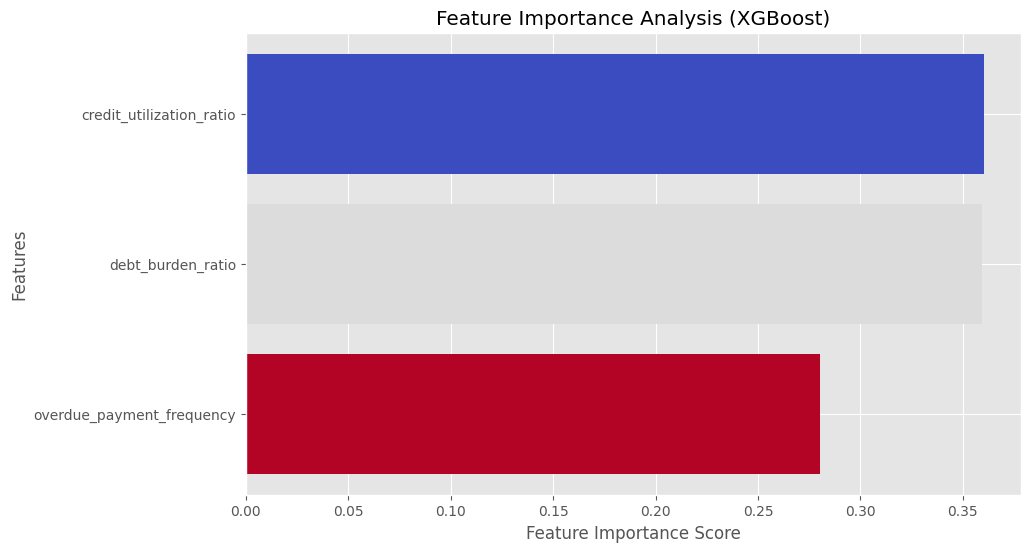

In [ ]:
# Function to evaluate model performance using common classification metrics
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

# Collecting results from all three models
results = [
    evaluate_model(y_test, log_reg_preds, "Logistic Regression"),
    evaluate_model(y_test, decision_tree_preds, "Decision Tree"),
    evaluate_model(y_test, xgb_preds, "XGBoost")
]

# Displaying the model performance comparison
results_df = pd.DataFrame(results)
#print(results_df)

# Analyzing which features were the most important in the XGBoost model
importances = xgb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]  # Sorting in descending order
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = importances[sorted_indices]

colors = plt.cm.coolwarm(np.linspace(0, 1, len(features)))

# Plot feature importance using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color=colors)  # Horizontal bar chart
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (XGBoost)")
plt.gca().invert_yaxis()  # Invert so most important is at the top
plt.style.use("ggplot")
plt.show()

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define number of folds
k_folds = 5
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Perform k-fold cross-validation and store detailed results
cross_val_results = []

# Perform k-fold cross-validation with additional metrics
metrics = ['accuracy', 'precision', 'recall', 'roc_auc']
for model_name, model in models.items():
    model_results = {"Model": model_name}
    for metric in metrics:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=stratified_kfold, scoring=metric)
        model_results[f"Mean {metric.capitalize()}"] = np.mean(scores)
        model_results[f"Std Dev {metric.capitalize()}"] = np.std(scores)
    cross_val_results.append(model_results)

# Convert results to DataFrame and display
cat_cross_val_results_df = pd.DataFrame(cross_val_results)
cat_cross_val_results_df

C:\Users\coope\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Mean Accuracy,Std Dev Accuracy,Mean Precision,Std Dev Precision,Mean Recall,Std Dev Recall,Mean Roc_auc,Std Dev Roc_auc
0,Logistic Regression,0.831818,0.000479,0.400000,0.374166,0.002703,0.002207,0.568964,0.009366
1,Decision Tree,0.768939,0.005526,0.196244,0.024284,0.120721,0.014913,0.501936,0.020076
2,XGBoost,0.824394,0.002110,0.254530,0.084399,0.026126,0.013179,0.545898,0.010992


In [ ]:
# Selecting the features we want to use for training our model
features = ['credit_utilization_ratio', 'overdue_payment_frequency', 'debt_burden_ratio', 
            'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11']
X = merged_data[features]  # Independent variables


In [ ]:
# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Some models (like Logistic Regression) work better with standardized data, so we scale it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing our machine learning models
log_reg = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)  # Logistic Regression for baseline performance
decision_tree = DecisionTreeClassifier(random_state=42)  # Decision Tree for non-linear decision making
xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # XGBoost for more advanced boosting-based predictions

# Training all three models
log_reg.fit(X_train_scaled, y_train)
decision_tree.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making predictions using our trained models
log_reg_preds = log_reg.predict(X_test_scaled)
decision_tree_preds = decision_tree.predict(X_test)
xgb_preds = xgb.predict(X_test)

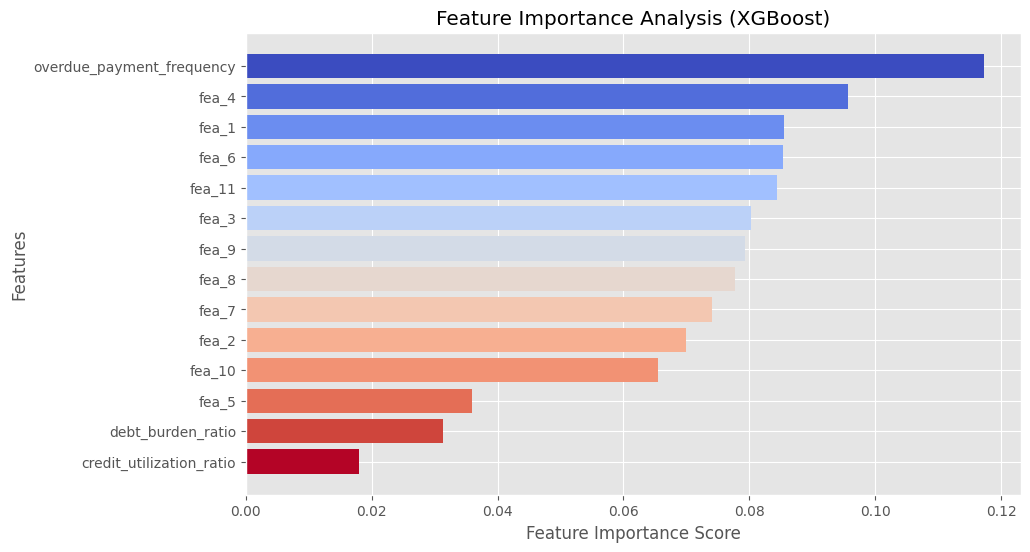

In [ ]:
# Function to evaluate model performance using common classification metrics
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

# Collecting results from all three models
results2 = [
    evaluate_model(y_test, log_reg_preds, "Logistic Regression"),
    evaluate_model(y_test, decision_tree_preds, "Decision Tree"),
    evaluate_model(y_test, xgb_preds, "XGBoost")
]

# Displaying the model performance comparison
results_df2 = pd.DataFrame(results2)
#print(results_df)

# Analyzing which features were the most important in the XGBoost model
importances = xgb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]  # Sorting in descending order
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = importances[sorted_indices]

colors = plt.cm.coolwarm(np.linspace(0, 1, len(features)))

# Plot feature importance using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color=colors)  # Horizontal bar chart
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (XGBoost)")
plt.gca().invert_yaxis()  # Invert so most important is at the top
plt.style.use("ggplot")
plt.show()

In [ ]:
print("Results without categorical (demographic) variables:\n", results_df)
print("\n \nResults with categorical (demographic) variables:\n", results_df2)

Results without categorical (demographic) variables:
                  Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression  0.832727   1.000000  0.003610  0.501805
1        Decision Tree  0.776364   0.201299  0.111913  0.511164
2              XGBoost  0.822424   0.214286  0.021661  0.502819

 
Results with categorical (demographic) variables:
                  Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression  0.832727   0.666667  0.007220  0.503246
1        Decision Tree  0.983030   0.956044  0.942238  0.966749
2              XGBoost  0.989697   0.996183  0.942238  0.970755


In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define number of folds
k_folds = 5
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Perform k-fold cross-validation and store detailed results
cross_val_results = []

# Perform k-fold cross-validation with additional metrics
metrics = ['accuracy', 'precision', 'recall', 'roc_auc']
for model_name, model in models.items():
    model_results = {"Model": model_name}
    for metric in metrics:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=stratified_kfold, scoring=metric)
        model_results[f"Mean {metric.capitalize()}"] = np.mean(scores)
        model_results[f"Std Dev {metric.capitalize()}"] = np.std(scores)
    cross_val_results.append(model_results)

# Convert results to DataFrame and display
cross_val_results_df = pd.DataFrame(cross_val_results)
cross_val_results_df

,Model,Mean Accuracy,Std Dev Accuracy,Mean Precision,Std Dev Precision,Mean Recall,Std Dev Recall,Mean Roc_auc,Std Dev Roc_auc
0,Logistic Regression,0.831818,0.000830,0.533333,0.323179,0.004505,0.002849,0.668461,0.023348
1,Decision Tree,0.979091,0.002899,0.940708,0.025916,0.936036,0.026937,0.961916,0.011246
2,XGBoost,0.987424,0.002693,0.988694,0.006223,0.936036,0.018983,0.989606,0.005517


In [ ]:
# Get probabilities from XGBoost
xgb_probabilities = xgb.predict_proba(X_test)[:, 1]  # Prob of default (1)

# Store in DataFrame
default_risk_df = X_test.copy()
default_risk_df["Default Probability"] = xgb_probabilities

# Display top results
#print(default_risk_df.head())
print(default_risk_df["Default Probability"].max())

0.9982857


C:\Users\coope\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


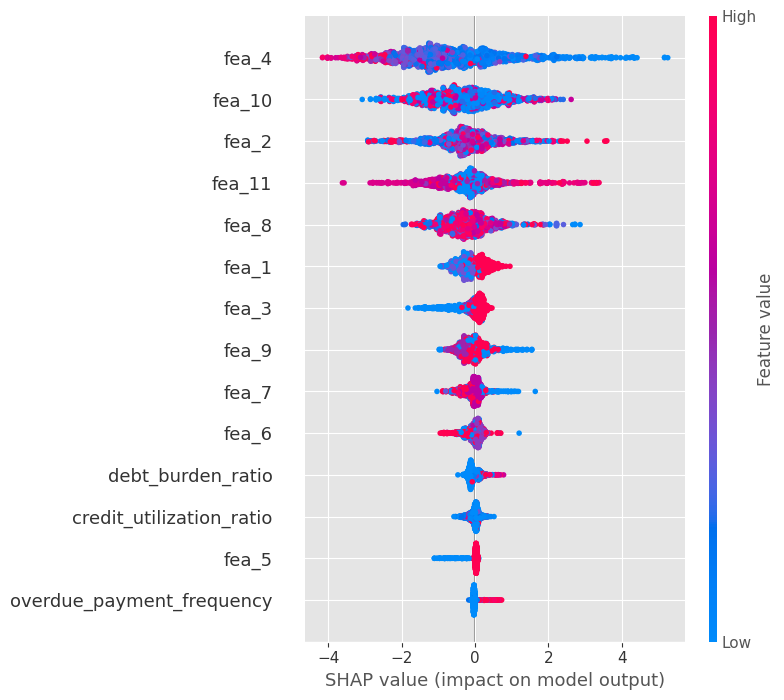

In [ ]:
import shap

# SHAP explainer plot
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test)

shap.initjs() 
shap_exp = shap.Explanation(values=shap_values.values, base_values=shap_values.base_values, data=X_test)
shap.force_plot(shap_exp.base_values[0], shap_exp.values[0], shap_exp.data.iloc[0])



Risk Category
Low Risk         1388
Moderate Risk      23
High Risk         239
Name: count, dtype: int64


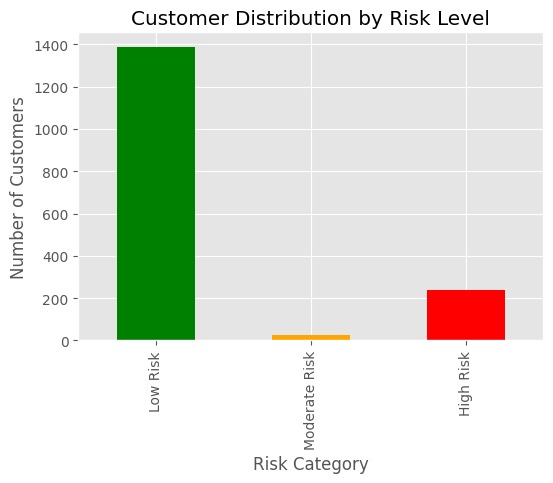

In [ ]:
# Define risk categories based on probability thresholds
def categorize_risk(prob):
    if prob >= 0.8:
        return "High Risk"
    elif prob >= 0.5:
        return "Moderate Risk"
    else:
        return "Low Risk"

# Apply to DataFrame
default_risk_df["Risk Category"] = default_risk_df["Default Probability"].apply(categorize_risk)

# Define the order of categories
category_order = ["Low Risk", "Moderate Risk", "High Risk"]

# Use .reindex() to order the counts correctly
risk_counts = default_risk_df["Risk Category"].value_counts().reindex(category_order, fill_value=0)
print(risk_counts)


# Plot
plt.figure(figsize=(6,4))
risk_counts.plot(kind="bar", color=["green", "orange", "red"])
plt.xlabel("Risk Category")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution by Risk Level")
plt.show()


In [ ]:
from scipy import stats

# Extract Accuracy and ROC-AUC scores from both cross-validation results
accuracy_1 = no_feature_cross_val_results_df["Mean Accuracy"]
roc_auc_1 = no_feature_cross_val_results_df["Mean Roc_auc"]

accuracy_2 = cat_cross_val_results_df["Mean Accuracy"]
roc_auc_2 = cat_cross_val_results_df["Mean Roc_auc"]

# Perform independent t-tests (Welch's t-test, assuming unequal variance)
t_stat_accuracy, p_value_accuracy = stats.ttest_ind(accuracy_1, accuracy_2, equal_var=False)
t_stat_roc_auc, p_value_roc_auc = stats.ttest_ind(roc_auc_1, roc_auc_2, equal_var=False)

# Store results in a DataFrame
t_test_results = pd.DataFrame({
    "Metric": ["Accuracy", "ROC-AUC"],
    "T-Statistic": [t_stat_accuracy, t_stat_roc_auc],
    "P-Value": [p_value_accuracy, p_value_roc_auc]
})

# Display the t-test results
print(t_test_results)



     Metric  T-Statistic   P-Value
0  Accuracy     2.296693  0.116240
1   ROC-AUC     3.260764  0.074622
